<a href="https://colab.research.google.com/github/ChaitanyaAwasthi/Generative-Adversarial-Networks/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [ ]:
!pip install imageio

In [9]:
import keras

In [ ]:
tf.keras.datasets.mnist.load_data(
    path ='mnist.npz'
)

In [12]:
(train_images, train_labels), (x_test, y_test) = keras.datasets.mnist.load_data()

In [15]:
# reshaping the images to what a cnn expects
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
train_images = (train_images - 127.5) / 127.5

In [17]:
BUFFER_SIZE = 60000 # randomize dataset for better training
BATCH_SIZE = 256 # number of data points trained on with each cycle of training

In [19]:
# we first slice the array into objects and then shuffle them, also distribute them according to batch_size
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

In [ ]:
plt.imshow()

# Coding the Models

In [21]:
from tensorflow.keras import layers

In [34]:
def generator_model():
    model = tf.keras.Sequential()
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,))) # makes an image, filled with noise
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Reshape((7, 7, 256)))
    assert model.output_shape == (None, 7, 7, 256)  # Note: None is the batch size

    model.add(layers.Conv2DTranspose(128, (5, 5), strides=(1, 1), padding='same', use_bias=False))
    assert model.output_shape == (None, 7, 7, 128)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False))
    assert model.output_shape == (None, 14, 14, 64)
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    model.add(layers.Conv2DTranspose(1, (5, 5), strides=(2, 2), padding='same', use_bias=False, activation='tanh'))
    assert model.output_shape == (None, 28, 28, 1)

    return model

# Apply Noise

In [38]:
import matplotlib.pyplot as plt


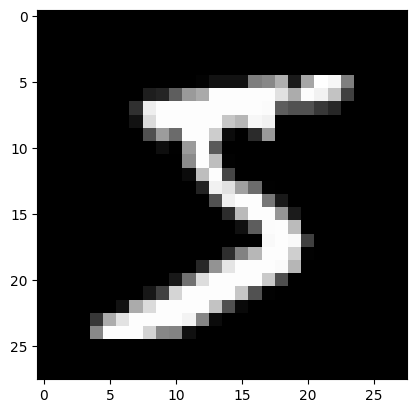

In [70]:
plt.imshow(train_images[0, :, :, 0], cmap='gray')

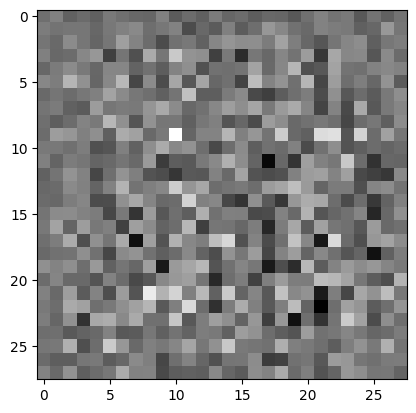

In [71]:
generator = generator_model() # whatever the function returns, it assigns to this variable

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
# ok so basically, we are choosing the first image, we are choosing all rows and columns of the image and choosing the first color given of the image



# Coding the Discriminator Model

In [93]:
def discriminator_model():
  model = tf.keras.Sequential()
  model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1])) # one single color channel

  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3)) #okay so the dropout function randomly drops the use of certain neurons, to reduce overfitting

  #upsampling
  model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  model.add(layers.Flatten()) #  converts multidimensional data into one dimension
  model.add(layers.Dense(1)) # outputs the probability (1_neuron) for whether the image is real or fake.


  return model

In [49]:
discriminator = discriminator_model()
decision = discriminator(generated_image)
print(decision)
# what if the discriminator does not judge the output the reverse engineers the output.
# the output clearly shows that the discriminator is showing that the image is fake...(created by an AI)

tf.Tensor([[0.00146443]], shape=(1, 1), dtype=float32)


# Coding the Loss and Optimizers

In [51]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True) # expecting the output to be in log-odd forms log(probability)[for better computation]

In [55]:
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output)    # tf.ones_like function assigns 1 to all the elements of same type
  fake_loss = cross_entropy(tf.ones_like(fake_output), fake_output)    # tf.ones_like represent labels, as it resembles the shape of the real_input showing that these real_output are actually true.
  total_loss = real_loss + fake_loss
  return total_loss

In [68]:
# quantified on how well the model was able to trick the discriminator.

def generator_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

# Defining two separate optimizers as we are training two different neural networks

In [63]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4) #learning_rate
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)


In [64]:
# Save checkpoints for the model
import os

checkpoint_dir = "./training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)



In [66]:
# Defining hyperparameters

EPOCHS = 50
noise_dim = 100 # the input dimension vector given to the gan
num_examples_to_generate = 16
seed = tf.random.normal([num_examples_to_generate, noise_dim])

In [67]:
seed

<tf.Tensor: shape=(16, 100), dtype=float32, numpy=
array([[-0.68503   , -0.4484445 ,  0.12197538, ...,  2.1047537 ,
         0.28085235,  0.45529422],
       [ 0.4591371 ,  0.4720142 ,  0.7444401 , ...,  0.43489495,
        -0.18252356, -0.09546457],
       [-0.21744202, -1.0207518 ,  0.09481269, ...,  1.5480424 ,
        -1.1261923 , -1.7532778 ],
       ...,
       [-0.2893343 , -0.8678065 , -1.0323638 , ...,  0.5146831 ,
        -0.7769685 ,  0.6052846 ],
       [ 0.13159618,  0.2792442 ,  0.11594237, ..., -0.9790321 ,
        -0.7353484 ,  0.79666954],
       [-0.7497193 , -0.8007021 , -2.119323  , ...,  0.90933424,
        -1.9240841 ,  0.85626835]], dtype=float32)>

In [69]:
@tf.function
def train_step(images):
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # Gradient tapes use memory to store intermediate results
  #trainable variables are the parameters or weights of the model that are updated during training to minimize the loss function.

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)


  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))



In [72]:
import time

In [82]:
def generate_and_save_images(model, epoch, test_input):

  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(4, 4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [79]:
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time

from IPython import display

In [91]:
def train(dataset, epoch):
  for epoch in range(epoch):
    start = time.time()

    for image_batch in dataset:
      train_step(image_batch)

    display.clear_output(wait=True)
    generate_and_save_images(generator, epoch+1, seed)

    if (epoch+1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))


    display.clear_output(wait=True)
    generate_and_save_images(generator , epoch, seed)

    print(f"Epoch {epoch + 1} is completed")

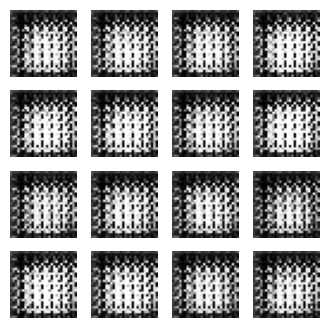

Epoch 1 is completed


KeyboardInterrupt: 

In [81]:
train(train_dataset, EPOCHS)